# Numerical bifurcation diagrams and bistable systems

Let us study the following system from :

\begin{equation}
\begin{cases}
\frac{du}{dt} = \frac{\alpha}{1+v^\beta} - u\\
\frac{dv}{dt} = \frac{\alpha}{1+u^\beta} - v
\end{cases}
\end{equation}

In [1]:
from functools import partial 
import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate #Integration library
from mpl_toolkits.mplot3d import axes3d
from collections import defaultdict
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
import cycler 
plt.rc('axes', prop_cycle=(cycler.cycler('color', colors)))

%matplotlib inline

## Drawing trajectories 

We start by inplementing the system in Python. 

A Cauchy problem under the form:

\begin{equation}
\begin{cases}
\frac{dy}{dt} = f(y,t)\\
y(0) = y_0
\end{cases}
\end{equation}

can be numerically solved on the interval $[0,T]$ with `scipy.integrate.ode(f, y0, time)`. 

In [2]:
def cellular_switch(y,t,alpha, beta):
    """ ODE system modeling Gardner's bistable cellular switch
    Args:
        y (array): (concentration of u, concentration of v)
        t (float): Time
        alpha (float): maximum rate of repressor synthesis 
        beta (float): degree of cooperative behavior.
    Return: dy/dt
    """
    u, v = y # you can use y[0], y[1] instead. 
    return np.array([(alpha/(1+v**beta)) - u ,
                     (alpha/(1+u**beta)) - v])

# We will look at those set of parameters
scenarios = [{'alpha':1, 'beta':2}, 
             {'alpha':1, 'beta':10}]

# Here is a list of interesting initial conditions:
initial_conditions = [(.1,1),(2,2),(1,1.3),(2,3),(2,1),(1,2)]

In [3]:
# Do the simulations.
# Remember that we define f as the partial application of cellular_switch. 
time = np.linspace(0,20,num=1000)
trajectory = {}
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        trajectory[i,j] = scipy.integrate.odeint(partial(cellular_switch, **param),
                                                 y0=ic,
                                                 t=time)

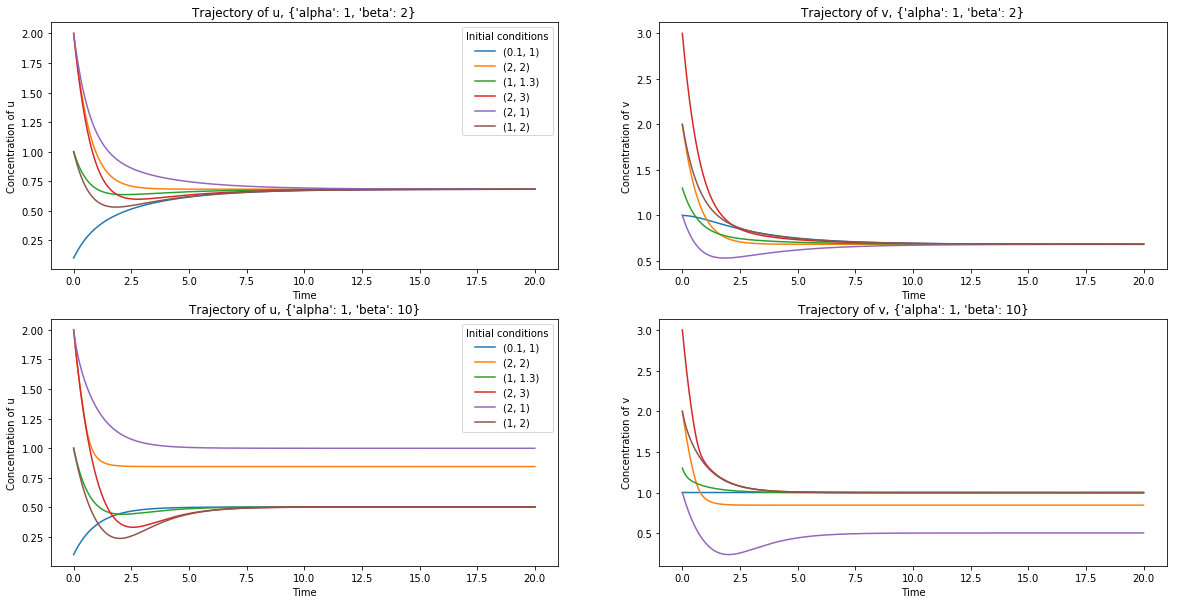

In [4]:
# Draw the trajectories. 
fig, ax = plt.subplots(2,2,figsize=(20,10))
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        ax[i][0].set(xlabel='Time', ylabel='Concentration of u', title='Trajectory of u, {}'.format(param))
        ax[i][1].set(xlabel='Time', ylabel='Concentration of v', title='Trajectory of v, {}'.format(param))
        l = ax[i][0].plot(time,trajectory[i,j][:,0], label=ic)
        ax[i][1].plot(time,trajectory[i,j][:,1], color=l[0].get_color())
    ax[i][0].legend(title='Initial conditions')

# Draw the phase diagram

## Isoclines
To find the null-isoclines, you have to solve:

\begin{equation}
\frac{du}{dt} = 0 \Leftrightarrow u = \frac{\alpha}{1 + v^\beta}
\end{equation}

For the first one and:

\begin{equation}
\frac{dv}{dt} = 0 \Leftrightarrow v = \frac{\alpha}{1 + u^\beta}
\end{equation}

For the second one. 

Now here is how we can draw them: 

In [5]:
def plot_isocline(ax, alpha, beta, color='k', style='--', opacity=.5):
    """Plot the isocline of the bistable cellular switch system"""
    x = np.linspace(0,2,100)
    ax.plot(x, alpha/(1+x**beta), style, color=color, alpha=opacity)
    ax.plot(alpha/(1+x**beta),x, style, color=color, alpha=opacity)

## Vector field 

The vector field is given by evaluting the derivative in all the points of the state space. You can use `streamplot` for a nice visual representation.

In [6]:
def plot_vector_field(ax, param, start=0, end=1.5, steps=25):
    # Compute the vector field
    x = np.linspace(start,end, steps)
    y = np.linspace(start,end, steps)
    X,Y = np.meshgrid(x,y)
    a = cellular_switch([X,Y],0,**param)   
    
    # streamplot is an alternative to quiver 
    # that looks nicer when your vector filed is
    # continuous.
    ax.streamplot(X,Y,a[0,:,:], a[1,:,:], color=(0,0,0,.1))
    
    ax.set(xlim=(start,end),ylim=(start,end))

## Equilibrium points 

Finding the equilibrium points is done by looking for the intersection of the two isocline curves. 

If the system is: 

\begin{equation}
\begin{cases}
\frac{du}{dt} = F(u,v)\\
\frac{du}{dt} = G(u,v)
\end{cases}
\end{equation}

We look for points where F(u,v)=G(u,v)=0

\begin{equation}
\frac{\alpha}{1+u^\beta} - \left(\frac{\alpha}{u}-1 \right)^\frac{1}{\beta}
\end{equation}

In [7]:
def find_unique_roots(function, starting_points):
    '''Return the list of unique root of function starting around starting_points'''
    eq = []
    for i0 in starting_points:
        new_eq = scipy.optimize.fsolve(function, i0)
        
        # This condition allow us to never store the same equilibrium twice
        if not eq or not any(all(x) for x in np.isclose(new_eq, eq)):
            eq.append(new_eq)
    return eq

equilibria = {}
for i, param in enumerate(scenarios):
    equilibria[i] = []
    
    # Find the position of the equilibirum around the endpoint of each trajectory. 
    derivative = partial(cellular_switch,t=0, **param)
    starting_points = [trajectory[i,j][-1,:] for j in range(len(initial_conditions))] 
    equilibria[i] = find_unique_roots(derivative, starting_points)
    
    print('{} Equilibrium point(s) for parameters: {}'.format(len(equilibria[i]), param))

1 Equilibrium point(s) for parameters: {'alpha': 1, 'beta': 2}
3 Equilibrium point(s) for parameters: {'alpha': 1, 'beta': 10}


## Nature of the equilbirum points
The nature of the equilibrium is given by looking at the jacobian

Let us compute the Jacobian of the system, 



The jacobian is: 

\begin{equation}
J \big \rvert_{u,v} = 
\begin{bmatrix}
    \frac{ \partial F(u,v)}{\partial u} &  \frac{ \partial F(u,v)}{\partial v}\\
    \frac{ \partial G(u,v)}{\partial u} &  \frac{ \partial G(u,v)}{\partial v}\\
\end{bmatrix} = - \begin{bmatrix}
    1 &  \frac{ \alpha \beta  v^{\beta-1}}{(1+v^\beta)^2}\\
    \frac{ \alpha \beta   u^{\beta-1}}{(1+u^\beta)^2}  &  1\\
\end{bmatrix}
\end{equation}

In [8]:
def jacobian_cellular_switch(u,v, alpha, beta):
    """ Jacobian matrix of the ODE system modeling Gardner's bistable cellular switch
    Args:
        u (float): concentration of u, 
        v (float): concentration of v,
        alpha (float): maximum rate of repressor synthesis, 
        beta (float): degree of cooperative behavior.
    Return: np.array 2x2"""
    return - np.array([[1, alpha*beta*v**(beta-1) / (1+v**beta)**2  ],
                       [alpha*beta*u**(beta-1) / (1+u**beta)**2, 1]])

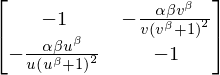

In [9]:
# Alternatively you can use Sympy (Symbolic python) to compute the derivative:
import sympy 
sympy.init_printing()

# Define variable as symbols for sympy
u, v = sympy.symbols("u, v")
alpha, beta = sympy.symbols("alpha, beta")

# Symbolic expression of the system
dudt = alpha/(1 + v**beta) - u
dvdt = alpha/(1 + u**beta) - v

# Symbolic expression of the matrix
sys = sympy.Matrix([dudt, dvdt])
var = sympy.Matrix([u, v])
jac = sys.jacobian(var)

# You can convert jac to a function:
jacobian_cellular_switch = sympy.lambdify((u, v, alpha, beta), jac, dummify=False)

jac

In [10]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point 
    """
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant,0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [11]:
# Find the nature of the equilibria
equilibria_nature = {}
for i, param in enumerate(scenarios):
    print('\nParameters: {}'.format(param))
    equilibria_nature[i] = []
    for (u,v) in equilibria[i]:
        equilibria_nature[i].append(stability(jacobian_cellular_switch(u,v, **param)))
        print("{} in ({} {})".format( equilibria_nature[i][-1], u,v,))


Parameters: {'alpha': 1, 'beta': 2}
Stable node in (0.6823278038280193 0.6823278038280194)

Parameters: {'alpha': 1, 'beta': 10}
Stable node in (0.5025684136901962 0.9989731530559247)
Saddle in (0.844397528792023 0.844397528792023)
Stable node in (0.9989731530559247 0.5025684136901961)


In [12]:
import matplotlib.patches as mpatches
EQUILIBRIUM_COLOR = {'Stable node':colors[0],
                    'Unstable node':colors[1], 
                    'Saddle':colors[4],
                    'Stable focus':colors[3],
                    'Unstable focus':colors[2],
                    'Center (Hopf)':colors[5],
                    'Transcritical (Saddle-Node)':colors[6]}
def plot_equilibrium(ax, position, nature, legend=True):
    """Draw equilibrium points at position with the color 
       corresponding to their nature"""
    for pos, nat in zip(position,nature):
        ax.scatter(pos[0],pos[1],
                   color= (EQUILIBRIUM_COLOR[nat] 
                           if nat in EQUILIBRIUM_COLOR
                           else 'k'),
                   zorder=100)
        
    if legend:
        # Draw a legend for the equilibrium types that were used.
        labels = list(frozenset(nature))
        ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels)

## Putting everything together

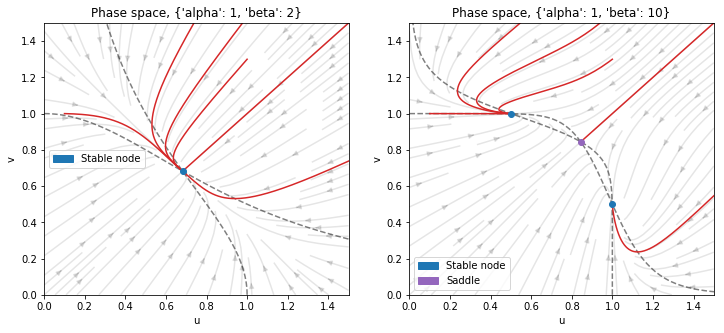

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(scenarios):
    ax[i].set(xlabel='u', ylabel='v', title="Phase space, {}".format(param))
    plot_vector_field(ax[i], param)
    plot_isocline(ax[i], **param)
    for j in range(len(initial_conditions)):
        ax[i].plot(trajectory[i,j][:,0],trajectory[i,j][:,1], color='C3')
    plot_equilibrium(ax[i], equilibria[i], equilibria_nature[i])

# Draw the bifurcation diagram

In [1]:
# Draw the bifurcation diagram for beta between 2 and 10. 
# Re-use the same methods than in the phase diagram.